# Phylogenetic signal across taxonomic groups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from statsmodels.stats.multitest import multipletests

In [3]:
from scipy.stats import kruskal, fligner, levene

In [4]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

Functions

In [5]:
def sig_sign(p):
    if p > 0.05:
        return 'ns'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    elif p > 0.0001:
        return '***'
    else:
        return '****'

Load data

In [6]:
df = pd.read_table('../phylogeny/place/fine_all.tsv', index_col = 0)
df['svratio'] = df['volume'] / df['surface']
df.shape

(5380, 23)

In [7]:
ranks = ['species', 'genus', 'family', 'order', 'class', 'phylum']

In [9]:
dfg = pd.read_table('../phylosig/physig/groups-lambda-sigsq.tsv')
dfg.shape

(74, 21)

Correct pvalues due to multiple testing using Benjamini/Hochberg

In [10]:
dfg['SV.pval0_corrected'] =  multipletests(dfg['SV.pval0'], alpha = 0.05, method = 'fdr_bh')[1]
dfg['SV.pval1_corrected'] =  multipletests(dfg['SV.pval1'], alpha = 0.05, method = 'fdr_bh')[1]

Assign higher ranks

In [11]:
dfg[ranks] = None
for idx, row in dfg.iterrows():
    target = df[df[row['rank']] == row['taxon']].iloc[0]
    for r in ranks[ranks.index(row['rank']):]:
        dfg.at[idx, r] = target[r]

Sort by rank

In [12]:
dfg.sort_values(ranks[::-1], ascending=False, inplace=True)

In [13]:
sigargs = dict(ha='left', va='center', family='monospace')

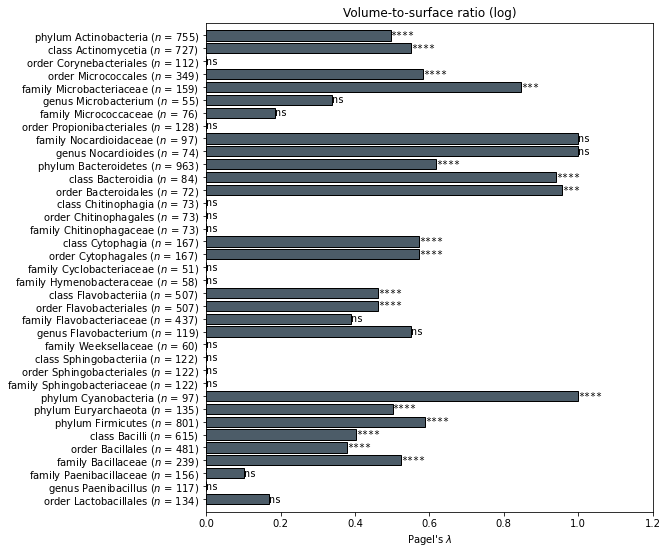

In [14]:
df_ = dfg.iloc[37:]

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure(figsize=(8, 9))
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0_corrected']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
plt.title('Volume-to-surface ratio (log)')

plt.show()

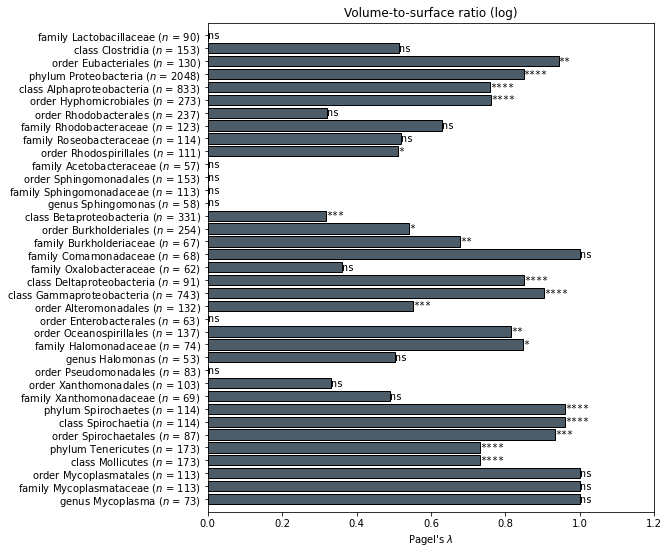

In [15]:
df_ = dfg.iloc[:37]

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure(figsize=(8, 9))
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0_corrected']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
plt.title('Volume-to-surface ratio (log)')

plt.show()

# Calculate mean, variance and standard deviation

In [16]:
ranks = ['genus', 'family', 'order', 'class', 'phylum']
ranks = ranks[::-1]

In [17]:
res = []
plambda = []
for rank in ranks:
    tmp = dfg[dfg['rank'] == rank]
    # Take only significant values
    data = tmp[tmp['SV.pval0_corrected'] < 0.05]['SV.lambda'].to_numpy()
#     data = tmp['SV.lambda'].to_numpy()
    if data.shape[0] > 0:
        res.append([rank, np.mean(data), np.var(data), np.std(data)])
        plambda.append(data)
    else:
        print(f'Rank {rank} has no significant values of Pagels lambda')

Rank genus has no significant values of Pagels lambda


In [18]:
dfr = pd.DataFrame(res, columns = ['rank', 'mean', 'var', 'std']).set_index('rank')
dfr.shape

(4, 3)

In [19]:
dfr

,mean,var,std
rank,,,
phylum,0.717976,0.034900,0.186815
class,0.677768,0.047023,0.216848
order,0.667799,0.037923,0.194739
family,0.724165,0.017970,0.134054


Plots

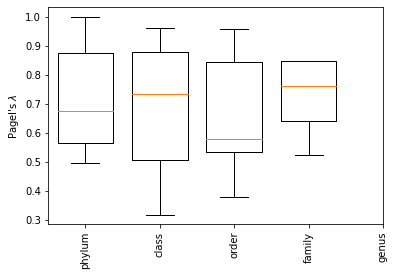

In [20]:
fig, ax = plt.subplots()
ax.boxplot(plambda, widths = 0.75, sym = 'k.')
ax.set_ylabel('Pagel\'s $\it{λ}$')
plt.xticks([i + 1 for i in range(len(ranks))], ranks, rotation = 90)
plt.show()

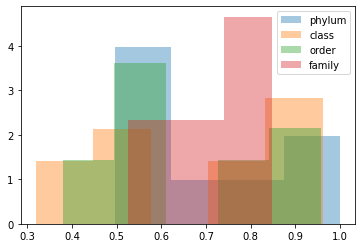

In [21]:
plt.figure()
for i, rank in enumerate(ranks[:-1]):
    plt.hist(plambda[i], label = rank, density = True, alpha = 0.4, bins = 'auto')
plt.legend()
plt.show()

Clearly data is not normal, but the empirical distribution has the same shape (except for phylum).

## We will use Levene's test --to test for homocedasticity among taxonomic levels

In [22]:
levene(plambda[0], plambda[1], plambda[2], plambda[3])
# levene(plambda[0], plambda[1], plambda[2], plambda[3], plambda[4])

LeveneResult(statistic=0.32189849422725936, pvalue=0.8094647725393066)

## Extra

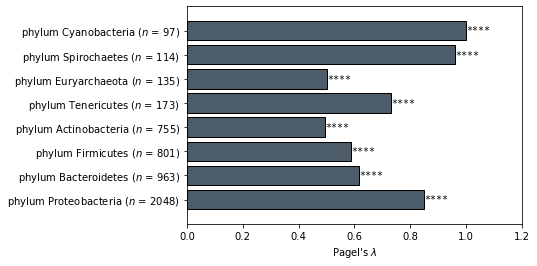

In [23]:
df_ = dfg[dfg['rank'] == 'phylum'].sort_values(by = 'count', ascending = False)

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure()
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
#plt.title('Volume-to-surface ratio (log)')

plt.show()

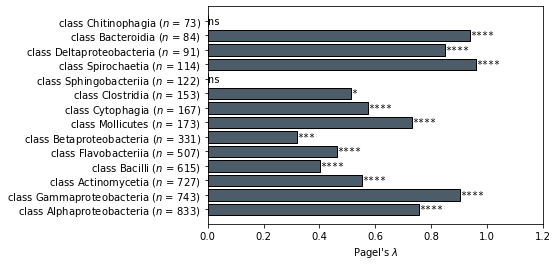

In [24]:
df_ = dfg[dfg['rank'] == 'class'].sort_values(by = 'count', ascending = False)

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure()
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
#plt.title('Volume-to-surface ratio (log)')

plt.show()

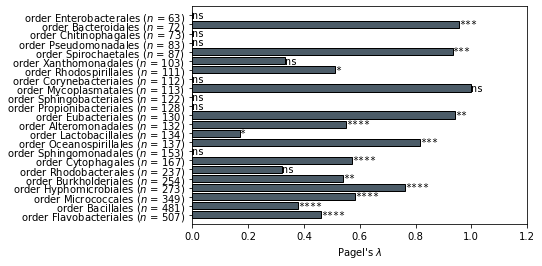

In [25]:
df_ = dfg[dfg['rank'] == 'order'].sort_values(by = 'count', ascending = False)

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure()
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
#plt.title('Volume-to-surface ratio (log)')

plt.show()

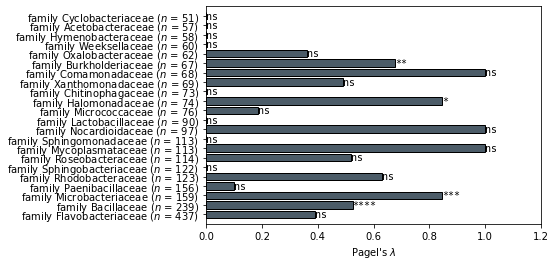

In [26]:
df_ = dfg[dfg['rank'] == 'family'].sort_values(by = 'count', ascending = False)

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure()
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
#plt.title('Volume-to-surface ratio (log)')

plt.show()

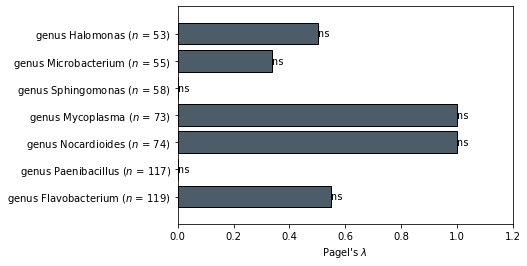

In [27]:
df_ = dfg[dfg['rank'] == 'genus'].sort_values(by = 'count', ascending = False)

yran = np.arange(df_.shape[0])
yticks = [f'{x.rank} {x.taxon} ($\it{{n}}$ = {x.count})' for x in df_.itertuples()]
plt.figure()
plt.barh(yran, df_['SV.lambda'], color = '#4c5c68', edgecolor = 'black')
for i, (_, x) in enumerate(df_.iterrows()):
    plt.text(x['SV.lambda'], i, sig_sign(x['SV.pval0']), **sigargs)
plt.ylim(yran[0] - 1, yran[-1] + 1)
plt.yticks(yran, yticks)
plt.xlim(0, 1.2)
plt.xlabel('Pagel\'s $\it{λ}$')
#plt.title('Volume-to-surface ratio (log)')

plt.show()

In [28]:
dfg[dfg['SV.pval0_corrected'] < 0.05][['taxon', 'rank', 'SV.lambda', 'phylum']]

,taxon,rank,SV.lambda,phylum
64,Mollicutes,class,0.732664,Tenericutes
74,Tenericutes,phylum,0.732664,Tenericutes
51,Spirochaetales,order,0.932941,Spirochaetes
66,Spirochaetia,class,0.960652,Spirochaetes
73,Spirochaetes,phylum,0.960645,Spirochaetes
15,Halomonadaceae,family,0.846972,Proteobacteria
44,Oceanospirillales,order,0.815763,Proteobacteria
30,Alteromonadales,order,0.552370,Proteobacteria
63,Gammaproteobacteria,class,0.904564,Proteobacteria
61,Deltaproteobacteria,class,0.850089,Proteobacteria


In [29]:
dfg[['taxon', 'rank', 'SV.lambda', 'phylum', 'SV.pval0_corrected']]

,taxon,rank,SV.lambda,phylum,SV.pval0_corrected
4,Mycoplasma,genus,1.000000e+00,Tenericutes,9.999999e-01
20,Mycoplasmataceae,family,1.000000e+00,Tenericutes,9.861139e-01
43,Mycoplasmatales,order,1.000000e+00,Tenericutes,9.861139e-01
64,Mollicutes,class,7.326643e-01,Tenericutes,1.612714e-13
74,Tenericutes,phylum,7.326643e-01,Tenericutes,1.612714e-13
...,...,...,...,...,...
18,Microbacteriaceae,family,8.465218e-01,Actinobacteria,4.045190e-04
42,Micrococcales,order,5.838192e-01,Actinobacteria,1.703821e-11
35,Corynebacteriales,order,3.147942e-131,Actinobacteria,9.999999e-01
53,Actinomycetia,class,5.516621e-01,Actinobacteria,3.752221e-13


In [30]:
dfg[['taxon', 'rank', 'SV.lambda', 'phylum', 'SV.pval0_corrected']].to_csv('pagels_lambda_taxa.csv', index = False)